In [1]:
# Imports
import time

import numpy
import numpy as np
import scipy
import tqdm
import reservoirpy
from reservoirpy import datasets
import matplotlib.pyplot as plt
from sklearn import linear_model

from reservoirpy.nodes import Reservoir, Ridge, ScikitLearnNode

reservoirpy.verbosity(0)

0

## Définition du dataset

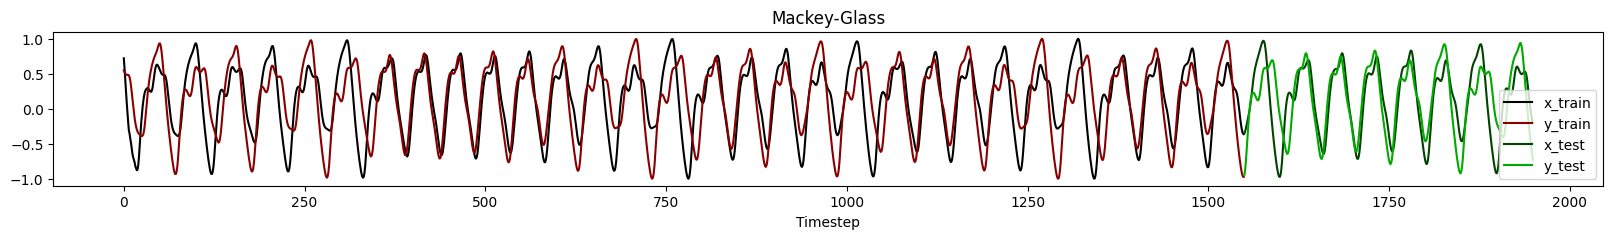

(1550, 1) (400, 1) (1550, 1) (400, 1)


In [2]:
# Dataset pour les tests
mackey_glass = datasets.mackey_glass(2000, tau=17)

# rescale between -1 and 1
mackey_glass = 2 * (mackey_glass - mackey_glass.min()) / (mackey_glass.max() - mackey_glass.min()) - 1

forecast = 50

mg_dataset = datasets.to_forecasting(
    mackey_glass, 
    forecast=forecast, 
    test_size=0.2
)
x_train, x_test, y_train, y_test = mg_dataset

import matplotlib.pyplot as plt

sep = x_train.shape[0]

plt.figure(figsize=(20,2))
plt.plot(np.arange(0, sep), x_train, color="black", label="x_train")
plt.plot(np.arange(0, sep), y_train, color="#880000", label="y_train")
plt.plot(np.arange(sep, sep+x_test.shape[0]), x_test, '-', color="#004400", label="x_test")
plt.plot(np.arange(sep, sep+y_test.shape[0]), y_test, '-', color="#00AA00", label="y_test")
plt.legend()
plt.xlabel("Timestep")
plt.title("Mackey-Glass")

plt.show()

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

## Définition de la méthode d'évaluation

In [3]:
Ns = np.array(np.exp(2.3*np.linspace(1.5, 4, 40)), dtype=int)[:-1]
Ns

array([  31,   36,   42,   49,   56,   65,   76,   88,  102,  118,  137,
        159,  184,  214,  248,  287,  333,  386,  447,  518,  601,  696,
        807,  935, 1084, 1256, 1455, 1687, 1955, 2265, 2625, 3042, 3526,
       4086, 4735, 5487, 6359, 7369, 8540])

In [4]:
def eval(N, iters, dataset):
    seed = 260_418
    x_train, x_test, y_train, y_test = dataset
    leak_rate = 0.3
    spectral_radius = 1.25
    input_scaling = 1.0
    connectivity = 0.1
    input_connectivity = 0.2

    scores = []
    for i in tqdm.tqdm(range(iters)):
        seed += 1
        reservoir = Reservoir(
            N,
            input_scaling=input_scaling, 
            sr=spectral_radius,
            lr=leak_rate, 
            rc_connectivity=connectivity,
            input_connectivity=input_connectivity, 
            seed=seed
        )
        # readout = Ridge(1, ridge=regularization)
        readout = ScikitLearnNode(linear_model.LinearRegression)

        model = reservoir >> readout
        
        model.fit(x_train, y_train)

        y_pred = model.run(x_test)
        score = reservoirpy.observables.nrmse(y_test, y_pred)
        scores.append(score)
    return scores

eval(Ns[-1], 1, mg_dataset)
# %timeit eval(1000, 10, mg_dataset) # 18.7s

100%|██████████| 1/1 [01:27<00:00, 87.44s/it]


[5.24565690009657]

100%|██████████| 10/10 [32:59<00:00, 197.97s/it]


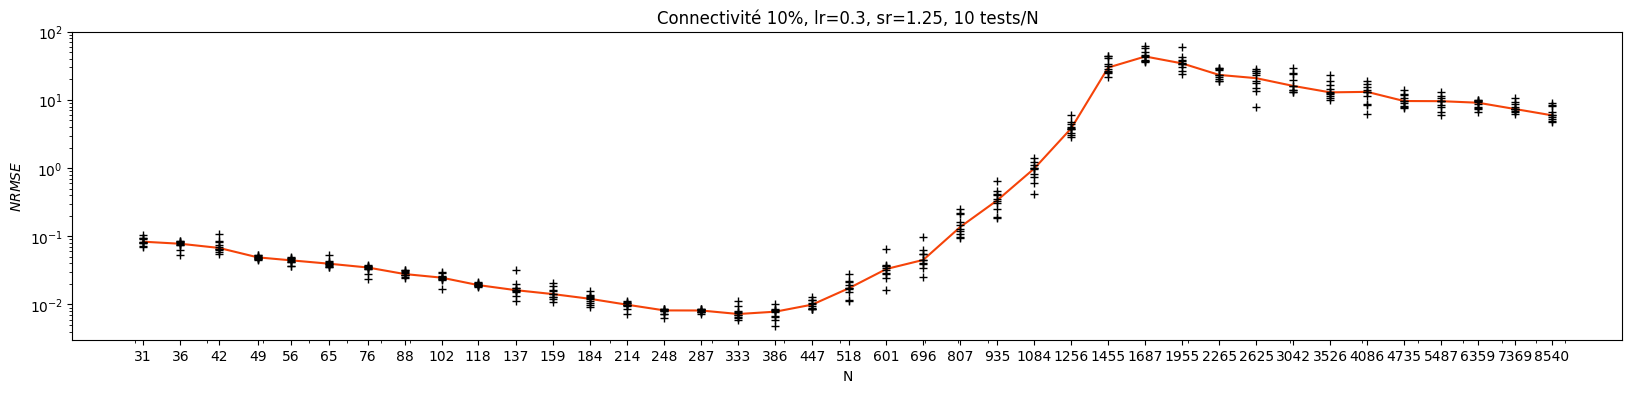

In [8]:
all_scores = []
for N in Ns:
    scores = eval(N, 10, mg_dataset)
    with open("./scores.txt", "a+") as file:
        print(scores, file=file)
    all_scores.append(scores)


plt.figure(figsize=(20,4))

plt.plot(Ns, [np.median(scores) for scores in all_scores], label="Médiane des iters")
plt.plot(Ns, all_scores, '+', color="black", label="Iteration")

plt.xscale("log"); plt.yscale("log")
plt.xlabel("N"); plt.ylabel("$NRMSE$")
plt.xticks(Ns, Ns)
plt.title("Connectivité 10%, lr=0.3, sr=1.25, 10 tests/N")
plt.legend()
plt.show()

In [9]:
np.save("./all_scores_10percent.npy", all_scores, allow_pickle=True)

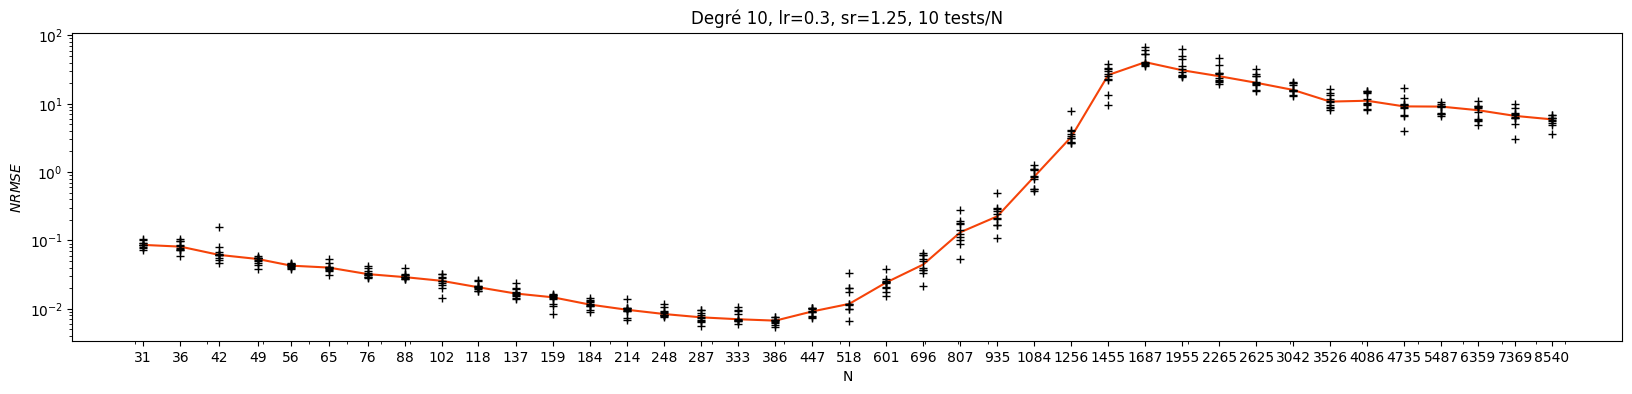

In [17]:
# sans échelle logarithmique (pour comparer avec le cas degree=10)
all_scores_degree10 = np.load("all_scores_degree10.npy")[:-1]
plt.figure(figsize=(20,4))

plt.plot(Ns, [np.median(scores) for scores in all_scores_degree10], label="Médiane des iters")
plt.plot(Ns, all_scores_degree10, '+', color="black", label="Iteration")

plt.xscale("log"); plt.yscale("log")
plt.xlabel("N"); plt.ylabel("$NRMSE$")
plt.xticks(Ns, Ns)
plt.title("Degré 10, lr=0.3, sr=1.25, 10 tests/N")
plt.show()

In [11]:
Ns[-8]

3042

# En fixant N, en faisant varier le rang

On fixe `N = 3_000` puisque une itération tourne en environ $12s$, et que 

$12s \times 10 itérations/rang \times 30 rangs = 3 600s = 1h$.

1h pour faire tourner les essais c'est très bien.

In [11]:
N = 3000

In [10]:
from reservoirpy.observables import spectral_radius as spec_rad

def sparse_with_rank(units, rank, connectivity, spectral_radius, rng):
    distr = scipy.stats.norm()
    distr.random_state = rng

    density = np.sqrt(1 - np.exp(np.log(1 - connectivity) / rank))
    m = scipy.sparse.random(units, rank, density=density, random_state=rng, data_rvs=distr.rvs)
    n = scipy.sparse.random(rank, units, density=density, random_state=rng, data_rvs=distr.rvs)

    W = m @ n
    sr = spec_rad(W, maxiter=300)

    return W * spectral_radius / sr

%timeit sparse_with_rank(units=3_000, rank=1_000, connectivity=0.1, spectral_radius=0.3, rng=13)

2.04 s ± 139 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
def eval_rank(N, rank, iters, dataset):
    seed = 260_418
    x_train, x_test, y_train, y_test = dataset
    leak_rate = 0.3
    spectral_radius = 1.25
    input_scaling = 1.0
    connectivity = 0.1
    input_connectivity = 0.2

    scores = []
    for i in tqdm.tqdm(range(iters)):
        seed += 1
        try:
            reservoir = Reservoir(
                W=sparse_with_rank(
                    units=N,
                    rank=rank,
                    connectivity=connectivity,
                    spectral_radius=spectral_radius,
                    rng=seed+1000,
                ),
                input_scaling=input_scaling, 
                lr=leak_rate,
                input_connectivity=input_connectivity,
                seed=seed,
            )
        except scipy.sparse.linalg.ArpackNoConvergence:
            print("ArpackNoConvergence", rank, i)
            continue
            
        # readout = Ridge(1, ridge=regularization)
        readout = ScikitLearnNode(linear_model.LinearRegression)

        model = reservoir >> readout
        
        model.fit(x_train, y_train)

        y_pred = model.run(x_test)
        score = reservoirpy.observables.nrmse(y_test, y_pred)
        scores.append(score)
    return scores

eval_rank(N, 100, 1, mg_dataset)


100%|██████████| 1/1 [00:06<00:00,  6.34s/it]


[2.550153283359788]

In [13]:
ranks = np.array(np.exp(2.3*np.linspace(1.5, 3.48, 30)), dtype=int)[:-1]
ranks

array([  31,   36,   43,   50,   59,   69,   80,   94,  110,  129,  151,
        177,  207,  242,  283,  332,  388,  454,  531,  622,  728,  852,
        997, 1166, 1364, 1596, 1868, 2186, 2557])


 50%|█████     | 5/10 [00:32<00:36,  7.36s/it]
ArpackNoConvergence 69 4
 40%|████      | 4/10 [00:28<00:48,  8.02s/it]
ArpackNoConvergence 94 3
 90%|█████████ | 9/10 [01:02<00:08,  8.06s/it]
ArpackNoConvergence 110 8
 20%|██        | 2/10 [00:21<01:27, 10.98s/it]
ArpackNoConvergence 177 1
 50%|█████     | 5/10 [00:44<00:51, 10.29s/it]
ArpackNoConvergence 622 4
100%|██████████| 10/10 [01:37<00:00,  9.75s/it]



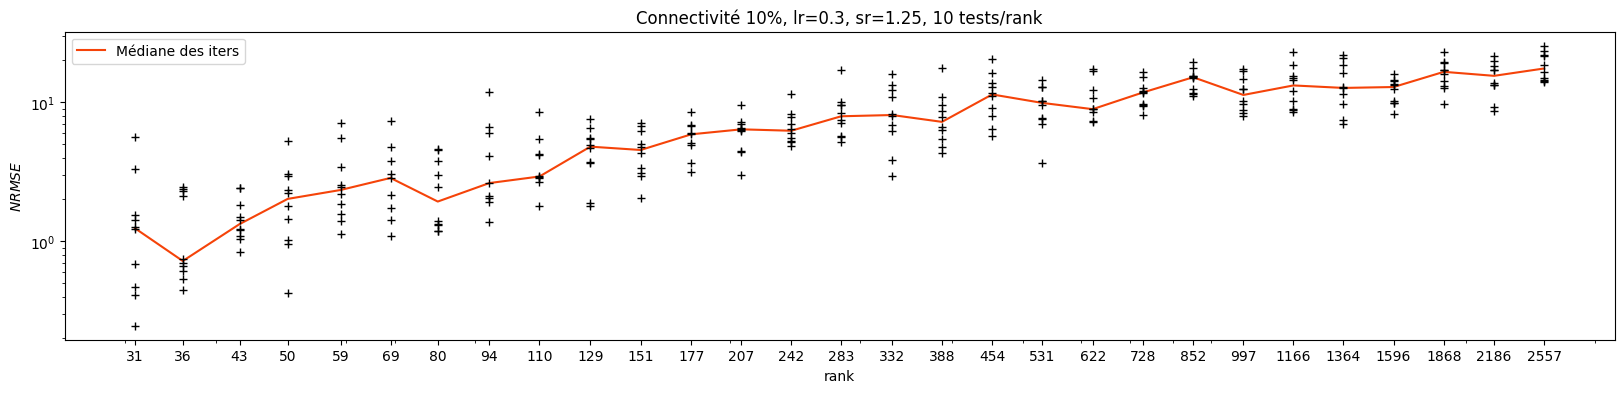

In [38]:
all_scores_rank = []
for rank in ranks:
    scores = eval_rank(N, rank, 10, mg_dataset)
    with open("./scores_rank.txt", "a+") as file:
        print(scores, file=file)
    all_scores_rank.append(scores)

plt.figure(figsize=(20,4))

plt.plot(ranks, [np.median(scores) for scores in all_scores_rank], label="Médiane des iters")
for rank, scores in zip(ranks, all_scores_rank):
    plt.plot([rank]*len(scores), scores, '+', color='black')

plt.xscale("log"); plt.yscale("log")
plt.xlabel("rank"); plt.ylabel("$NRMSE$")
plt.xticks(ranks, ranks)
plt.title("Connectivité 10%, lr=0.3, sr=1.25, 10 tests/rank")
plt.legend()
plt.show()

# Avec N=300

N=300 donne les meilleurs scores, donc on peut faire pareil avec N = 300, juste pour voir si on a la même tendance

In [47]:
N = 300
ranks = np.array(np.exp(2.3*np.linspace(1.5, 2.48, 30)), dtype=int)[:-1]
ranks

array([ 31,  34,  36,  39,  42,  46,  50,  54,  58,  63,  68,  74,  80,
        86,  93, 101, 109, 118, 127, 137, 149, 161, 174, 188, 203, 219,
       237, 256, 277])

100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


ArpackNoConvergence 109 9


 70%|███████   | 7/10 [00:03<00:01,  2.10it/s]

ArpackNoConvergence 174 6


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


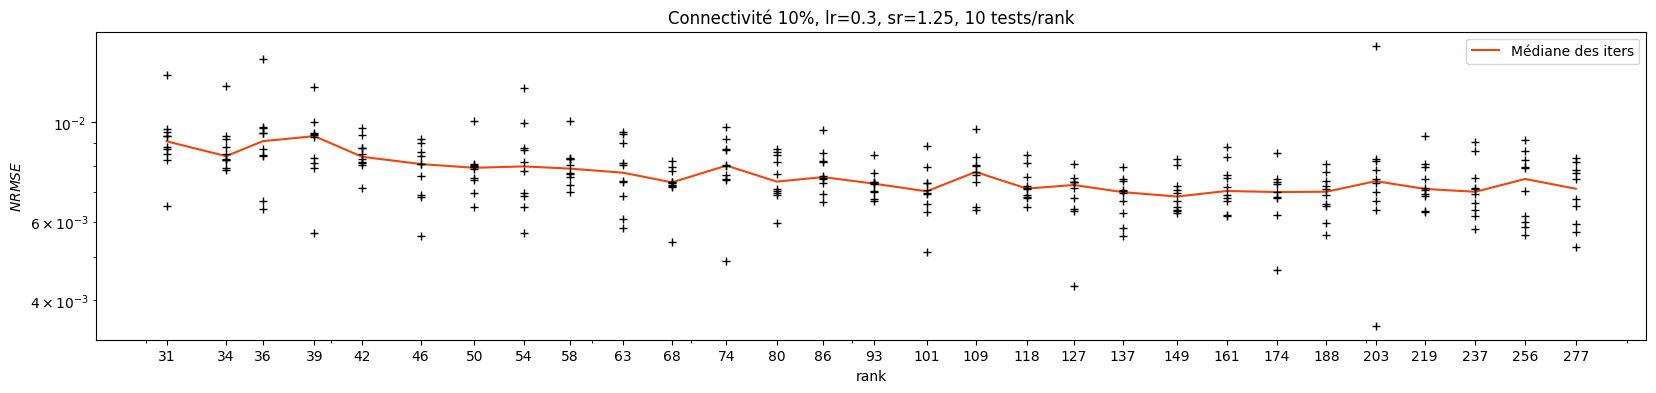

In [48]:
all_scores_rank300 = []
for rank in ranks:
    scores = eval_rank(N, rank, 10, mg_dataset)
    with open("./scores_rank_300.txt", "a+") as file:
        print(scores, file=file)
    all_scores_rank300.append(scores)

plt.figure(figsize=(20,4))

plt.plot(ranks, [np.median(scores) for scores in all_scores_rank300], label="Médiane des iters")
for rank, scores in zip(ranks, all_scores_rank300):
    plt.plot([rank]*len(scores), scores, '+', color='black')

plt.xscale("log"); plt.yscale("log")
plt.xlabel("rank"); plt.ylabel("$NRMSE$")
plt.xticks(ranks, ranks)
plt.title("Connectivité 10%, lr=0.3, sr=1.25, 10 tests/rank")
plt.legend()
plt.show()

# : Matrice qui fait buguer la convergence Arpack

Il y a une itération qui a tourné pendant plusieurs minutes, ce qui m'a incité à rajouter un try except pour que le tout ne tourne pas trop longtemps. J'ai isolé ici la matrice si jamais un jour je cherche à comprendre ce qui ne va pas avec elle.

In [7]:
distr = scipy.stats.norm()
distr.random_state = 261_422
rng = 261_422
connectivity=0.1

density = np.sqrt(1 - np.exp(np.log(1 - connectivity) / 94))
m = scipy.sparse.random(3_000, 94, density=density, random_state=rng, data_rvs=distr.rvs)
n = scipy.sparse.random(94, 3_000, density=density, random_state=rng, data_rvs=distr.rvs)

W = m @ n

In [9]:
sr = spec_rad(W, maxiter=300)

ArpackNoConvergence: ARPACK error -1: No convergence (1001 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]